In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]


The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
season = ""
episode = ""
scene = ""
data = []
with open("data/all_scripts.txt") as f:
    for line in f.readlines():
        line = line[:-1]
        if line.startswith(">> "):
            season = int(line[10:12])
            episode = line[3:]
            continue
        if line.startswith("> "):
            scene = line[2:]
            continue
        character, line = line.split(": ", 1)
        data.append([season, episode, scene, character, line])
lines = pd.DataFrame(data, columns=["Season", "Episode", "Scene", "Character", "Line"])

In [3]:
lines.groupby(["Season", "Episode", "Scene"]).count().reset_index().groupby("Season").count()[["Scene"]]

,Scene
Season,
1,157
2,205
3,193
4,219
5,198
6,211
7,207
8,191
9,177


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [4]:
lines_per_chars = lines.groupby("Character").count()[["Line"]]
recurrent_chars = lines_per_chars[lines_per_chars["Line"] > 90]
recurrent_chars

,Line
Character,
Amy,3472
Arthur,130
Bernadette,2690
Bert,95
Beverley,162
Emily,164
Howard,5872
Kripke,106
Leonard,9829


In [5]:
recurrent_chars = recurrent_chars.drop("Man", axis=0)
recurrent_chars

,Line
Character,
Amy,3472
Arthur,130
Bernadette,2690
Bert,95
Beverley,162
Emily,164
Howard,5872
Kripke,106
Leonard,9829


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [6]:
def clean_line(line):
    for char in EXCLUDE_CHARS:
        line = line.replace(char, ' ')
    return line.lower()
lines["Line"] = lines["Line"].apply(clean_line)
lines.head()

,Season,Episode,Scene,Character,Line
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed what s your point
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,there s no point i just think it s a good ide...
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,excuse me
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,hang on


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [7]:
corpus_frequency = pd.concat([pd.Series(row['Line'].split(' ')) for _, row in lines.iterrows()]).reset_index()
corpus_frequency.columns = ["Frequency", "Word"]
corpus_frequency = corpus_frequency.groupby("Word").count()

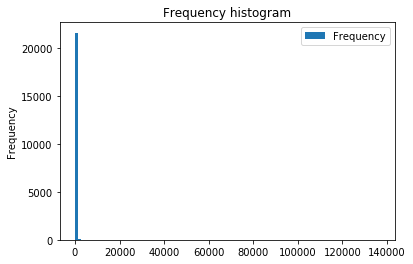

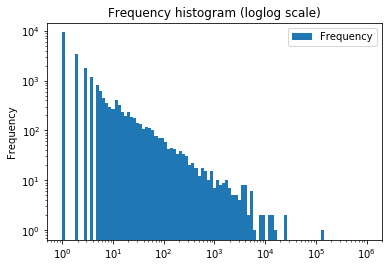

In [8]:
corpus_frequency.plot.hist(by="Frequency", bins=100, title="Frequency histogram")
corpus_frequency.plot.hist(by="Frequency", loglog=True, bins=np.logspace(0, 6, 100),
                           title="Frequency histogram (loglog scale)");

The distribution of frequencies follows a power law. The correct way to visualize this frequency is on a log-log scale.

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [9]:
lines["Words"] = lines["Line"].apply(lambda x: len(x.split(' ')))
words_per_char = lines.groupby("Character").sum()["Words"]
words_per_char[recurrent_chars.index]

Character
Amy              47997
Arthur            1933
Bernadette       33510
Bert              1407
Beverley          2447
Emily             1930
Howard           84388
Kripke            1538
Leonard         126078
Leslie            1541
Mrs Cooper        4060
Mrs Wolowitz      1757
Penny            99517
Priya             2424
Raj              73039
Sheldon         223272
Stuart            9773
Wil               2022
Zack              1775
Name: Words, dtype: int64

In [10]:
print("Most talkative character: ", words_per_char[recurrent_chars.index].idxmax())

Most talkative character:  Sheldon


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high. Leonard also suspects that it's easier for Sheldon to distinguish the lines that _aren't_ his, rather than those that _are_. We want you to put on the (proverbial) detective's hat and to investigate this claim.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons. Each of your data points (which is one row of your matrix) is one **dialogue line**. Now, use the scikit-learn class **TfIdfVectorizer** to create TF-IDF representations for the data points in your training and test sets. Note that since you're going to train a machine learning model, everything used in the training needs to be independent of the test set. As a preprocessing step, remove stopwords and words that appear only once from your vocabulary. Use the simple tokenizer provided in `helpers/helper_functions.py` as an input to the TfidfVectorizer class, and use the words provided in `helpers/stopwords.txt` as your stopwords.

In [11]:
train_set = lines[lines["Season"] <= lines["Season"].max() - 2]
train_set.head()

,Season,Episode,Scene,Character,Line,Words
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...,62
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed what s your point,7
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,there s no point i just think it s a good ide...,18
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,excuse me,3
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,hang on,3


In [12]:
test_set = lines[lines["Season"] > lines["Season"].max() - 2]
test_set.head()

,Season,Episode,Scene,Character,Line,Words
40354,9,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Penny,so what package are you thinking,8
40355,9,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Leonard,mm this one comes with music and flowers oh ...,23
40356,9,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Penny,why would we want that,6
40357,9,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Leonard,‘cause there s a lot of gorgeous blondes out t...,29
40358,9,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Penny,whatever put us on the internet i ve always ...,19


In [13]:
with open("helpers/stopwords.txt") as f:
    stop_words = list(map(lambda x: x[:-1], f.readlines()))
tfidf = TfidfVectorizer(stop_words=stop_words, tokenizer=simple_tokeniser, min_df=2)
train_vectors = tfidf.fit_transform(train_set["Line"])
test_vectors = tfidf.transform(test_set["Line"])

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [14]:
words_for_chars = pd.concat([pd.Series(row["Character"], row['Line'].split(' '))
                             for _, row in lines.iterrows()]).reset_index()
words_for_chars.columns = ["Word", "Character"]

words_for_chars = words_for_chars.groupby("Word")["Character"].apply(set)
sheldon_words = words_for_chars[words_for_chars.apply(lambda x: ("Sheldon" in x) and (len(x) == 1))].index

In [15]:
def contains_sheldon_words(line):
    for word in sheldon_words:
        if word in line:
            return True
    return False
test_pred = test_set["Line"].apply(contains_sheldon_words)
test_true = test_set["Character"] == "Sheldon"

In [16]:
print("Accuracy: ", (test_true == test_pred).sum() / len(test_true))

Accuracy:  0.3656061437191443


We know that a line that contains a word that is only said by Sheldon has to be said by Sheldon. But how many of Sheldon's line contain those words?

We first need to isolate the words that are only said by Sheldon, (`sheldon_words`), by first associating each word in the line to the character of the line, then grouping by words and keeping only the ones that contain only "Seldon" as `Character`. 37% of his lines actually contain his special words (on the test set)

**Q8**. Now, perform singular value decomposition (SVD) on the training TF-IDF matrix, and calculate a **25-dimensional approximation** for both the training and test TF-IDF matrices (you can do this using scikit-learn's **TruncatedSVD** class). Then, train a logistic regression classifier with 10-fold cross-validation (using the scikit-learn **LogisticRegressionCV** class) on the output of the SVD that given a dialogue line, tells you whether it's by Sheldon or by someone else.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**i)** Report precision, recall and F1-score for both classes (Sheldon and not-Sheldon), as well as accuracy, of your classifier on the training set and the test set. You need to implement the calculation of the evaluation measures (precision, etc.) yourself -- using the scikit-learn functions for them is not allowed.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**ii)** What difference do you observe between the model's scores on the training and test sets? What could you infer from the amount of difference you see? What about the difference between scores on the two classes? Given the performance of your classifier, is Leonard right that the accuracy Sheldon claims is unattainable? What about his suspicions about the lines that Sheldon can and cannot distinguish?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iii)** List 10 of the most extreme false positives and 10 of the most extreme false negatives, in terms of the probabilities predicted by the logistic regression model. What are common features of false positives? What about the false negatives?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iv)** What is the most important feature in the model? What are the 5 most important words in this feature? _Hint: Think of the definition of an SVD, and that you did an SVD on the TF-IDF matrix with dialogue lines as rows and words as columns. You have projected the original data points onto a 25-dimensional subspace -- you need to look at the unit vectors you used for the projection._

In [17]:
svd = TruncatedSVD(n_components=25)
train_svd = svd.fit_transform(train_vectors)
test_svd = svd.transform(test_vectors)

In [18]:
model = LogisticRegressionCV(cv=10)
train_labels = train_set["Character"] == "Sheldon"
model.fit(train_svd, train_labels)
test_pred = model.predict(test_svd)
train_pred = model.predict(train_svd)

In [19]:
def confusion_matrix(test, pred, positive=1):
    negative = 0 if positive == 1 else 1
    cm = np.zeros((2,2))
    test = test.values
    cm[0,0] = np.logical_and(pred == positive, test == positive).sum()
    cm[0,1] = np.logical_and(pred == positive, test == negative).sum()
    cm[1,0] = np.logical_and(pred == negative, test == positive).sum()
    cm[1,1] = np.logical_and(pred == negative, test == negative).sum()
    df = pd.DataFrame(cm.astype(int), columns=["Positive", "Negative"])
    df.index = ["Positive Prediction", "Negative Prediction"]
    return df

def accuracy(confusion_matrix):
    return (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()

def precision(confusion_matrix):
    if (confusion_matrix[0,:].sum() == 0):
        return 1
    return confusion_matrix[0,0] / confusion_matrix[0,:].sum()

def recall(confusion_matrix):
    if (confusion_matrix[:,0].sum() == 0):
        return 1
    return confusion_matrix[0,0] / confusion_matrix[:,0].sum()

def fscore(confusion_matrix):
    p = precision(confusion_matrix)
    r = recall(confusion_matrix)
    return 2 * p * r / (p+r)

def stats(confusion_matrix):
    confusion_matrix = confusion_matrix.values
    return {"accuracy": accuracy(confusion_matrix), "precision":precision(confusion_matrix),
            "recall": recall(confusion_matrix), "fscore": fscore(confusion_matrix)}

print("Statistics for class 1 on train set:\n", stats(confusion_matrix(train_labels, train_pred, positive=1)))
print("Statistics for class 0 on train set:\n", stats(confusion_matrix(train_labels, train_pred, positive=0)))
print("Statistics for class 1 on test set:\n", stats(confusion_matrix(test_true, test_pred, positive=1)))
print("Statistics for class 0 on test set:\n", stats(confusion_matrix(test_true, test_pred, positive=0)))

Statistics for class 1 on train set:
 {'accuracy': 0.7663676463299797, 'precision': 0.5576923076923077, 'recall': 0.012272534913245875, 'fscore': 0.024016563146997932}
Statistics for class 0 on train set:
 {'accuracy': 0.7663676463299797, 'precision': 0.7674488118367957, 'recall': 0.9970228464177076, 'fscore': 0.8673009796194122}
Statistics for class 1 on test set:
 {'accuracy': 0.7947522398976047, 'precision': 0.3181818181818182, 'recall': 0.0031291908806437194, 'fscore': 0.00619743249225321}
Statistics for class 0 on test set:
 {'accuracy': 0.7947522398976047, 'precision': 0.7957127152803225, 'recall': 0.9982760602229629, 'fscore': 0.8855584442065557}


The fscore on class 1 is low for both the train and test sets. This is due to bad recall for both, as it means our True-Positive Rate is bad (only few of the elements categorized as positive are actually positive). This is not the case for class 0, which means that our model is actually better at detecting if a line is not from Sheldon, rather than to detect if it is from him.

In [20]:
proba = model.predict_proba(test_svd)
to_class = lambda x: [0, 1] if x == 1 else [1, 0]
test_class = np.array([to_class(i) for i in test_true])
pred_class = test_class * proba

In [21]:
print("10 most extreme false negatives")
test_set.iloc[pred_class[:,0].argsort()[:10]]["Line"].values

10 most extreme false negatives


array([' knock  knock  knock  amy   knock  knock  knock  amy   knock  knock  knock  amy  will you marry me ',
       'hello ', 'all right  hello ',
       'yeah  but you ve got all those things  and no one s lining up to be you ',
       'why are you shaking  are you cold ', 'why ',
       'i tried to let go of anger and threw a rock into my foot ',
       'neither do i  but we can find out together ',
       'ow  ow  ow  ow  ow  ow  ow  ow…',
       'uh  do you really think calling me names is helpful '],
      dtype=object)

In [22]:
print("10 most extreme false positives")
test_set.iloc[pred_class[:,1].argsort()[:10]]["Line"].values

10 most extreme false positives


array(['so  what package are you thinking ',
       'you re right  it sells itself ',
       'you have to admit  it s a pretty smooth ride ',
       'i was hoping it d be quieter ',
       'if childbirth is half this bad  you are so screwed  are we there yet ',
       'soon ', 'why is it taking so long ',
       'fine  we ll go to the e r  just stop selling me on the van ',
       'howard  howard  look at the dvd screen  i put on batman  the animated series  your favourite ',
       'i ve been babysitting him way longer than you have '],
      dtype=object)

In [27]:
best_components = np.abs(svd.components_).argmax(axis=1)
list(np.array(tfidf.get_feature_names())[best_components])

['hey',
 'hey',
 'sheldon',
 'right',
 'really',
 'well',
 'thank',
 'going',
 'thank',
 'good',
 'sure',
 'sorry',
 'sorry',
 'want',
 'think',
 'get',
 'come',
 'like',
 'hi',
 'great',
 'penny',
 'll',
 'hello',
 'got',
 'say']

Above are shown the words that have the maximum value in each of the svd projection components.